In [1]:
import numpy as np
import os
import compress_multiphoton as compress
import matplotlib.pyplot as plt
import colorcet as cc
import pathlib
from sklearn.linear_model import HuberRegressor as Regressor
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy import ndimage
from matplotlib.colors import hsv_to_rgb
from matplotlib.transforms import Bbox
import matplotlib

# First Figure

In [2]:
scan = np.load('../testdata/movie1.npz')['scan']
file = 'movie1'
binning = 1

In [3]:
scan.shape

(500, 320, 248)

In [4]:
figure_filename = pathlib.Path('./figures') / f"{file}"
qs = compress.compute_sensitivity(scan.transpose(1, 2, 0), count_weight_gamma=1)
print('{f}\nQuantal size: {sensitivity:5.1f}\nIntercept: {zero_level:5.1f}\n'.format(f=figure_filename, **qs))


q = qs['sensitivity']
b = qs['zero_level']
counts = qs['counts']

figures/movie1
Quantal size:  96.9
Intercept: 100.8



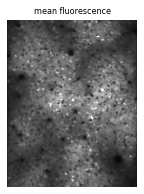

In [5]:
# Panel A

fig = plt.figure(figsize=(1.8, 2.6))
gs = fig.add_gridspec(
    1, 1,
    left=0.0, right=1.0, bottom=0.0, top=0.9)

ax = fig.add_subplot(gs[0])

matplotlib.rc('font', family='sans', size=8)

m = scan.mean(axis=0)
_ = ax.imshow(m, vmin=0, vmax=np.quantile(m, 0.999), cmap='gray')
ax.axis(False)
ax.set_title('mean fluorescence')
ax.title.set_size(8)
fig.savefig(str(figure_filename) + '-A.png', dpi=300)


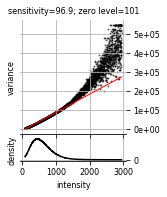

In [6]:
# Panel B
from matplotlib.ticker import FormatStrFormatter
matplotlib.rc('font', family='sans', size=8)

x = np.arange(qs["min_intensity"], qs["max_intensity"])

fig = plt.figure(figsize=(2.2, 2.8))
gs = fig.add_gridspec(
    2, 1, height_ratios=(5, 1),
    left=0.08, right=0.75, bottom=0.15, top=0.85, hspace = 0.05)

ah = fig.add_subplot(gs[1])
ah.yaxis.tick_right()
ah.plot(x/binning, counts, 'k')
ah.spines['top'].set_visible(False)
ah.spines['right'].set_visible(False)
#ah.spines['bottom'].set_visible(False)
ah.spines['left'].set_visible(False)
ah.set_ylabel('density')
ah.set_xlabel('intensity')
ah.set_yticks([0])
ah.grid(True)

ax = fig.add_subplot(gs[0])
ax.yaxis.tick_right()
fit = qs["model"].predict(x.reshape(-1, 1))
ax.scatter(x/binning, np.float64(np.minimum(fit[-1]*2, qs["variance"])/binning), s=1, color='k', alpha=0.5)
ax.plot(x / binning, fit / binning, 'red', lw=1, alpha=1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0e'))
ax.spines['bottom'].set_visible(True)
plt.setp(ax.get_xticklabels(), visible=False)

ax.grid(True)
ax.set_ylabel('variance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('sensitivity={sensitivity:0.1f}; zero level={zero_level:0.0f}'.format(**qs))
ax.title.set_size(8)


fig.savefig(str(figure_filename) + '-B.png', dpi=300)

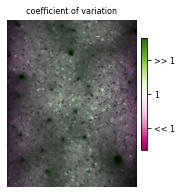

In [7]:
fig = plt.figure(figsize=(1.8*1.3, 2.6))
matplotlib.rc('font', family='sans', size=8)
gs = fig.add_gridspec(
    1, 1, 
    left=0.0, right=1.0/1.3, bottom=0.0, top=0.9)
ax = fig.add_subplot(gs[0])
v = ((scan[1:,:,:].astype('float64') - scan[:-1,:,:]) ** 2/2).mean(axis=0)
imx = np.stack(((m-b)/q, v/q/q, (m-b)/q), axis=-1)
img = ax.imshow(np.minimum(1, np.sqrt(0.01 + np.maximum(0, imx/np.quantile(imx, 0.9999))) - 0.1), cmap='PiYG')

cax = fig.add_axes([1.03/1.3, 0.2, 0.04, 0.6])
cbar = plt.colorbar(img, cax=cax, ticks=[0.2, .5, 0.8], shrink = 0.5)
cbar.ax.set_yticklabels(['<< 1', '1', '>> 1'])  
ax.axis(False)
ax.set_title('coefficient of variation')
ax.title.set_size(8)

fig.savefig(str(figure_filename) + '-C.png', dpi=300)

In [8]:
# segmentation and trace extraction
flux = (scan - qs['zero_level']) / qs['sensitivity']

activity_map = (flux[::2,:,:]+flux[1::2,:,:]).max(axis=0)/2 - flux.mean(axis=0)  # 
mask =  activity_map > activity_map.max() * 0.5
labels = ndimage.label(mask)[0]

sizes = np.array([np.sum(labels==i) for i in np.unique(labels)])
labels[np.logical_or(sizes > 22, sizes < 20)[labels]] = 0

uniq_labels = np.unique(labels)[1:]
traces = np.stack([flux[:,labels == label].sum(axis=1) for label in uniq_labels])  

In [9]:
traces.shape

(8, 500)

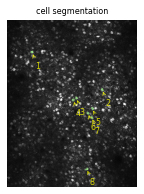

In [10]:
fig = plt.figure(figsize=(1.8, 2.6))
matplotlib.rc('font', family='sans', size=8)
gs = fig.add_gridspec(
    1, 1,
    left=0.0, right=1, bottom=0.0, top=0.9)
ax = fig.add_subplot(gs[0])

# segmentation
im = activity_map
hsv = np.minimum(
    1, 
    np.stack((
        np.ones_like(im)*0.3, # hue 
        (labels > 0) * 0.4,  # saturation
        (1.1 + 0.0 * (labels > 0)) * im / im.max()  # value
    ), axis=-1))
ax.imshow(hsv_to_rgb(hsv));
for i, (y, x) in enumerate(ndimage.center_of_mass(im, labels, np.unique(labels)[1:]),1):
    ax.annotate(str(i), (x, y), (x+5, y+30), color='yellow', fontsize=8, alpha=0.8, 
                arrowprops=dict(
                    facecolor='yellow', edgecolor='yellow', 
                    arrowstyle='->', lw=0.5, alpha=1.0))
ax.axis(False)

ax.set_title('cell segmentation');
ax.title.set_size(8)

fig.savefig(str(figure_filename) + '-D.png', dpi=300)


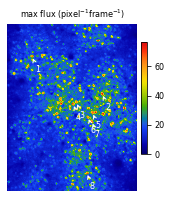

In [11]:
fig = plt.figure(figsize=(1.8 * 1.3, 2.6))
matplotlib.rc('font', family='sans', size=8)
gs = fig.add_gridspec(
    1, 1, 
    left=0.0, right=1.0/1.3, bottom=0.0, top=0.9)
ax = fig.add_subplot(gs[0])

im = flux.max(axis=0)
mx = np.quantile(im, 0.999)
im[im<0] = np.nan
img = ax.imshow(im, vmin=-0.0*mx, vmax=mx, cmap=cc.cm.CET_R4)

cax = fig.add_axes([1.03/1.3, 0.2, 0.04, 0.6])

plt.colorbar(img, cax=cax, shrink=0.5)
ax.axis(False)
ax.set_title('max flux (pixel$^{-1}$frame$^{-1}$)');
ax.title.set_size(8)

for i, (y, x) in enumerate(ndimage.center_of_mass(im, labels, np.unique(labels)[1:]),1):
    ax.annotate(str(i), (x, y), (x+5, y+30), color='white', fontsize=8, alpha=1.0, 
                arrowprops=dict(
                    facecolor='white', edgecolor='white', 
                    arrowstyle='->', lw=1, alpha=1.0))


fig.savefig(str(figure_filename) + '-E.png', dpi=300)


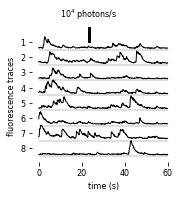

In [12]:
fig = plt.figure(figsize=(2.4, 2.6))
gs = fig.add_gridspec(
    1, 1, 
    left=0.18, right=1.0, bottom=0.15, top=0.85)

dt = 0.12
ax = fig.add_subplot(gs[0])
x = np.arange(qs["min_intensity"], qs["max_intensity"])

time = np.r_[:traces.shape[1]] * dt
offset = np.c_[:traces.shape[0]].T + 0.5
ax.plot(time, traces.T / dt /10000 + offset, 'k', lw=1.0);
ax.plot(time, traces.T * 0 + offset, 'k', lw=0.25);
ax.set_frame_on(False)
n = len(traces)
ax.set_yticks(np.r_[n:0:-1])
ax.set_yticklabels(np.r_[1:n+1])
ax.set_ylabel('cell number')
ax.set_xlabel('time (s)')
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel('fluorescence traces')

scalebar = AnchoredSizeBar(ax.transData,
                           1, '$10^4$ photons/s', 'upper right', 
                           pad=0.1,
                           color='black',
                           label_top=True,
                           borderpad=0.5, 
                           sep=5,
                           bbox_to_anchor=Bbox.from_bounds(0, 0, 0.7, 1.0),
                           bbox_transform=ax.figure.transFigure,
                           frameon=False,
                           size_vertical=1)
ax.add_artist(scalebar)

fig.savefig(str(figure_filename) + '-F.png', dpi=300)


### Extra: video compression

Compress the selected sequence and report the compression rate.

In [13]:
# make compression lookup tables
zero = np.int16(np.round(qs['zero_level']))
LUT1, LUT2 = compress.make_luts(
    zero_level=0, 
    sensitivity=qs['sensitivity'],
    input_max=scan.max() - zero,
    beta=0.5
)

Text(0.5, 1.0, 'compressed-decompressed')

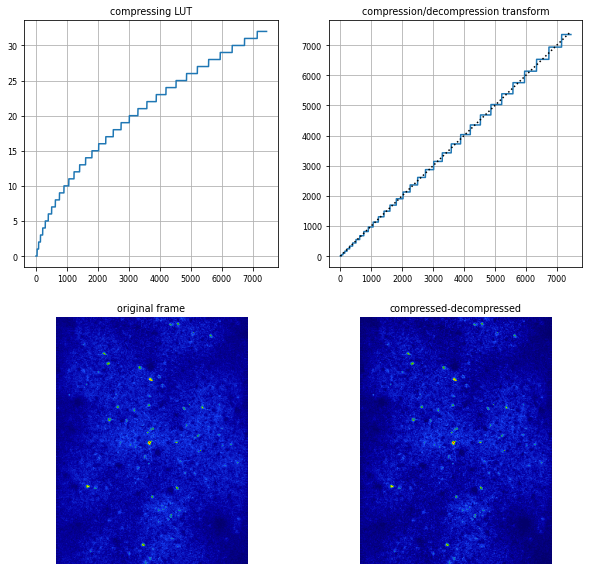

In [14]:
fig, axx = plt.subplots(2, 2, figsize=(10, 10))
axx = iter(axx.flatten())

ax = next(axx)
ax.plot(LUT1)
ax.grid(True)
ax.set_title('compressing LUT')

ax = next(axx)
ax.plot(LUT2[LUT1])
ax.plot(np.r_[:LUT1.size], np.r_[:LUT1.size], 'k:')
ax.grid(True)
ax.set_title('compression/decompression transform')

ax = next(axx)
frame = scan[300,:,:]
ax.imshow(frame, cmap=cc.cm.CET_R4)
ax.axis(False)
ax.set_title('original frame')

ax = next(axx)
compressed = compress.lookup(frame - zero, LUT1)
decompressed = compress.lookup(compressed, LUT2) + zero
ax.imshow(decompressed, cmap=cc.cm.CET_R4)
ax.axis(False)
ax.set_title('compressed-decompressed')

In [15]:
# save compressed video as .gif
compressed = compress.lookup(scan - zero, LUT1)
gif_path = str(figure_filename) + '.gif'
compress.save_movie(compressed, gif_path, scale=255//np.max(compressed))        
print(f'Compression ratio: {np.prod(scan.shape)*2 / os.path.getsize(gif_path):0.2f}')

Compression ratio: 3.86


In [16]:
decompressed = compress.lookup(compressed, LUT2) + zero

# Second Figure

In [17]:
scan = np.load('../testdata/movie2.npz')['scan']
file = 'movie2'
binning = 1

In [18]:
    
figure_filename = pathlib.Path('./figures') / f"{file}"
qs = compress.compute_sensitivity(scan.transpose(1, 2, 0), count_weight_gamma=0.0001)
print('{f}\nQuantal size: {sensitivity:5.1f}\nIntercept: {zero_level:5.1f}\n'.format(f=figure_filename, **qs))


q = qs['sensitivity']
b = qs['zero_level']
counts = qs['counts']

figures/movie2
Quantal size: 678.7
Intercept: -334.9



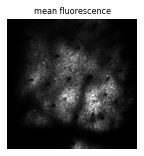

In [19]:
fig = plt.figure(figsize=(1.8, 2.6))
gs = fig.add_gridspec(
    1, 1,
    left=0.0, right=1.0, bottom=0.0, top=0.9)

ax = fig.add_subplot(gs[0])


matplotlib.rc('font', family='sans', size=8)

m = scan.mean(axis=0)
_ = ax.imshow(m, vmin=0, vmax=np.quantile(m, 0.999), cmap='gray')
ax.axis(False)
ax.set_title('mean fluorescence')
ax.title.set_size(8)
fig.savefig(str(figure_filename) + '-A.png', dpi=300)

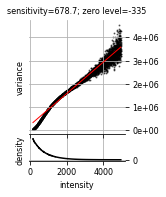

In [20]:
# Panel B
from matplotlib.ticker import FormatStrFormatter
matplotlib.rc('font', family='sans', size=8)

x = np.arange(qs["min_intensity"], qs["max_intensity"])

fig = plt.figure(figsize=(2.2, 2.8))
gs = fig.add_gridspec(
    2, 1, height_ratios=(5, 1),
    left=0.14, right=0.75, bottom=0.15, top=0.85, hspace = 0.05)

ah = fig.add_subplot(gs[1])
ah.yaxis.tick_right()
ah.plot(x/binning, counts, 'k')
ah.spines['top'].set_visible(False)
ah.spines['right'].set_visible(False)
#ah.spines['bottom'].set_visible(False)
ah.spines['left'].set_visible(False)
ah.set_ylabel('density')
ah.set_xlabel('intensity')
ah.set_yticks([0])
ah.grid(True)

ax = fig.add_subplot(gs[0])
ax.yaxis.tick_right()
fit = qs["model"].predict(x.reshape(-1, 1))
ax.scatter(x/binning, np.float64(np.minimum(fit[-1]*2, qs["variance"])/binning), s=1, color='k', alpha=0.5)
ax.plot(x / binning, fit / binning, 'red', lw=1, alpha=1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0e'))
ax.spines['bottom'].set_visible(True)
plt.setp(ax.get_xticklabels(), visible=False)

ax.grid(True)
ax.set_ylabel('variance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('sensitivity={sensitivity:0.1f}; zero level={zero_level:0.0f}'.format(**qs))
ax.title.set_size(8)


fig.savefig(str(figure_filename) + '-B.png', dpi=300)


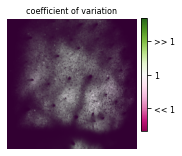

In [21]:
fig = plt.figure(figsize=(1.8*1.3, 2.6))
matplotlib.rc('font', family='sans', size=8)
gs = fig.add_gridspec(
    1, 1, 
    left=0.0, right=1.0/1.3, bottom=0.0, top=0.9)
ax = fig.add_subplot(gs[0])
v = ((scan[1:,:,:].astype('float64') - scan[:-1,:,:]) ** 2/2).mean(axis=0)
imx = np.stack(((m-b)/q, v/q/q, (m-b)/q), axis=-1)
img = ax.imshow(np.minimum(1, np.sqrt(0.01 + np.maximum(0, imx/np.quantile(imx, 0.9999))) - 0.1), cmap='PiYG')

cax = fig.add_axes([1.03/1.3, 0.2, 0.04, 0.6])
cbar = plt.colorbar(img, cax=cax, ticks=[0.2, .5, 0.8], shrink = 0.5)
cbar.ax.set_yticklabels(['<< 1', '1', '>> 1'])  
ax.axis(False)
ax.set_title('coefficient of variation')
ax.title.set_size(8)

fig.savefig(str(figure_filename) + '-C.png', dpi=300)

In [22]:
# segmentation and trace extraction
flux = (scan - qs['zero_level']) / qs['sensitivity']

activity_map = (flux[::2,:,:]+flux[1::2,:,:]).max(axis=0)/2 - flux.mean(axis=0)  # 
mask =  activity_map > activity_map.max() * 0.3
labels = ndimage.label(mask)[0]

sizes = np.array([np.sum(labels==i) for i in np.unique(labels)])
labels[np.logical_or(sizes > 100, sizes < 80)[labels]] = 0

uniq_labels = np.unique(labels)[1:]
traces = np.stack([flux[:,labels == label].sum(axis=1) for label in uniq_labels])  

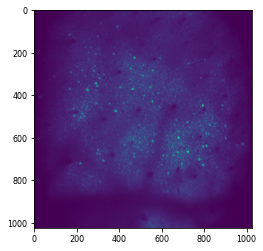

In [23]:
plt.imshow(activity_map)

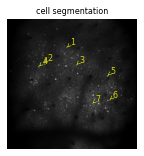

In [24]:
fig = plt.figure(figsize=(1.8, 2.6))
matplotlib.rc('font', family='sans', size=8)
gs = fig.add_gridspec(
    1, 1,
    left=0.0, right=1, bottom=0.0, top=0.9)
ax = fig.add_subplot(gs[0])

# segmentation
im = activity_map
hsv = np.minimum(
    1, 
    np.stack((
        np.ones_like(im)*0.3, # hue 
        (labels > 0) * 0.4,  # saturation
        (1.1 + 0.0 * (labels > 0)) * im / im.max()  # value
    ), axis=-1))
ax.imshow(hsv_to_rgb(hsv));
for i, (y, x) in enumerate(ndimage.center_of_mass(im, labels, np.unique(labels)[1:]),1):
    ax.annotate(str(i), (x+3, y-3), (x+25, y-25), color='yellow', fontsize=8, alpha=0.8, 
                arrowprops=dict(
                    facecolor='yellow', edgecolor='yellow', 
                    arrowstyle='->', lw=0.5, alpha=1.0))
ax.axis(False)

ax.set_title('cell segmentation');
ax.title.set_size(8)

fig.savefig(str(figure_filename) + '-D.png', dpi=300)

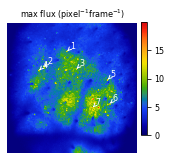

In [25]:
fig = plt.figure(figsize=(1.8 * 1.3, 2.6))
matplotlib.rc('font', family='sans', size=8)
gs = fig.add_gridspec(
    1, 1, 
    left=0.0, right=1.0/1.3, bottom=0.0, top=0.9)
ax = fig.add_subplot(gs[0])

im = flux.max(axis=0)
mx = np.quantile(im, 0.999)
im[im<0] = np.nan
img = ax.imshow(im, vmin=-0.0*mx, vmax=mx, cmap=cc.cm.CET_R4)

cax = fig.add_axes([1.03/1.3, 0.2, 0.04, 0.6])

plt.colorbar(img, cax=cax, shrink=0.5)
ax.axis(False)
ax.set_title('max flux (pixel$^{-1}$frame$^{-1}$)');
ax.title.set_size(8)

for i, (y, x) in enumerate(ndimage.center_of_mass(im, labels, np.unique(labels)[1:]),1):
    ax.annotate(str(i), (x+3, y-3), (x+25, y-25), color='white', fontsize=8, alpha=1.0, 
                arrowprops=dict(
                    facecolor='white', edgecolor='white', 
                    arrowstyle='->', lw=1, alpha=1.0))


fig.savefig(str(figure_filename) + '-E.png', dpi=300)


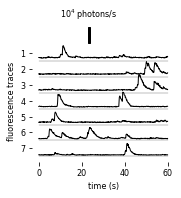

In [26]:
fig = plt.figure(figsize=(2.4, 2.6))
gs = fig.add_gridspec(
    1, 1, 
    left=0.18, right=1.0, bottom=0.15, top=0.80)

dt = 0.12
ax = fig.add_subplot(gs[0])
x = np.arange(qs["min_intensity"], qs["max_intensity"])

time = np.r_[:traces.shape[1]] * dt
offset = np.c_[:traces.shape[0]].T + 0.5
ax.plot(time, traces.T / dt /10000 + offset, 'k', lw=1.0);
ax.plot(time, traces.T * 0 + offset, 'k', lw=0.25);
ax.set_frame_on(False)
n = len(traces)
ax.set_yticks(np.r_[n:0:-1])
ax.set_yticklabels(np.r_[1:n+1])
ax.set_ylabel('cell number')
ax.set_xlabel('time (s)')
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel('fluorescence traces')

scalebar = AnchoredSizeBar(ax.transData,
                           1, '$10^4$ photons/s', 'upper right', 
                           pad=0.1,
                           color='black',
                           label_top=True,
                           borderpad=0.5, 
                           sep=5,
                           bbox_to_anchor=Bbox.from_bounds(0, 0, 0.7, 1.0),
                           bbox_transform=ax.figure.transFigure,
                           frameon=False,
                           size_vertical=1)
ax.add_artist(scalebar)

fig.savefig(str(figure_filename) + '-F.png', dpi=300)


### Extra: video compression

Compress the selected sequence and report the compression rate.

In [27]:
# make compression lookup tables
zero = np.int16(np.round(qs['zero_level']))
LUT1, LUT2 = compress.make_luts(
    zero_level=0, 
    sensitivity=qs['sensitivity'],
    input_max=scan.max() - zero,
    beta=0.5
)

Text(0.5, 1.0, 'compressed-decompressed')

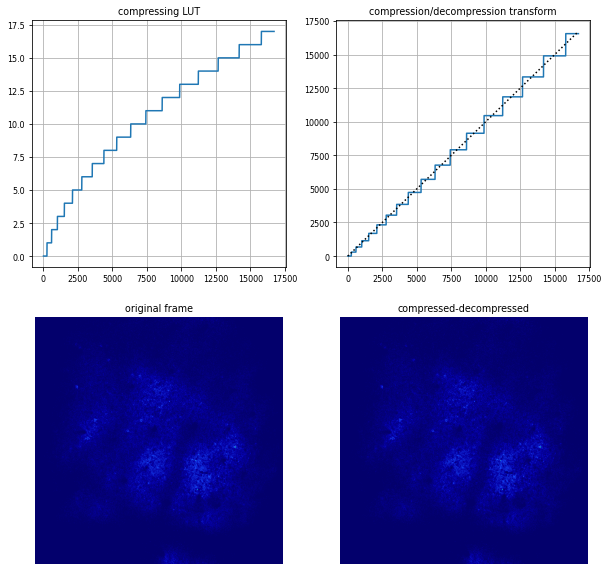

In [28]:
fig, axx = plt.subplots(2, 2, figsize=(10, 10))
axx = iter(axx.flatten())

ax = next(axx)
ax.plot(LUT1)
ax.grid(True)
ax.set_title('compressing LUT')

ax = next(axx)
ax.plot(LUT2[LUT1])
ax.plot(np.r_[:LUT1.size], np.r_[:LUT1.size], 'k:')
ax.grid(True)
ax.set_title('compression/decompression transform')

ax = next(axx)
frame = np.maximum(0, np.minimum(scan[300,:,:], LUT1.size-1))
ax.imshow(frame, cmap=cc.cm.CET_R4)
ax.axis(False)
ax.set_title('original frame')

ax = next(axx)
ax.imshow(LUT2[LUT1[frame]], cmap=cc.cm.CET_R4)
ax.axis(False)
ax.set_title('compressed-decompressed')

In [29]:
compressed = compress.lookup(scan - zero, LUT1)
gif_path = str(figure_filename) + '.gif'
compress.save_movie(compressed, gif_path, scale=255//np.max(compressed))        
print(f'Compression ratio: {np.prod(scan.shape)*2 / os.path.getsize(gif_path):0.2f}')

Compression ratio: 10.74


In [30]:
decompressed = compress.lookup(compressed, LUT2) + zero